In [33]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [34]:
final_result = np.load('u_v1_v2_t_4_em4_random_basis_mesh_30_2_2_pmap_over_filling.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
filling_arr = final_result['filling']
filling_mesh, u_mesh = np.meshgrid(filling_arr, u_arr, indexing = 'ij')

In [35]:
np.max(final_c_difference)

np.float64(0.0005151632418366183)

In [36]:
np.max(final_e_difference)

np.float64(1.416074107085663e-06)

### Some points do not converge that well, but ignore it first

In [37]:
index_c_diff = np.where(np.abs(final_c_difference)>1E-4)
final_ground_state_e_diff_density[index_c_diff] = 0
index_e_diff = np.where(np.abs(final_e_difference)>1E-4)
final_ground_state_e_diff_density[index_e_diff] = 0

In [38]:
index_c_diff

(array([ 5,  5,  5,  5,  5,  7,  7,  8, 11, 19, 19]),
 array([ 8,  8,  8,  8,  8,  4, 15,  2,  8, 15, 15]),
 array([ 6,  7, 13, 14, 19,  4, 15, 11,  5,  9, 16]))

In [39]:
final_c_difference[index_c_diff]

array([0.00024628, 0.00051516, 0.00019119, 0.00018391, 0.00013063,
       0.00022733, 0.00012278, 0.00014084, 0.00044952, 0.00015696,
       0.00016537])

### Phase Analysis

In [40]:
from functions_parameters.tools import rot_symm_m_check_d, translation_check_d
from functions_parameters.universal_parameters import pauli_matrices

translation_a1 = np.kron(np.array([[0,0,1,0],
                           [0,0,0,1],
                           [1,0,0,0],
                           [0,1,0,0]]), np.eye(3))
translation_a2 = np.kron(np.array([[0,1,0,0],
                           [1,0,0,0],
                           [0,0,0,1],
                           [0,0,1,0]]), np.eye(3))
c_6_uc = np.array([[0,0,1],
                   [1,0,0],
                   [0,1,0]])
c_3_uc = c_6_uc@c_6_uc
c_2_uc = c_6_uc @ c_3_uc
c_6_2uc = np.zeros((12, 12))
c_6_2uc[0, 2] = 1
c_6_2uc[1, 6] = 1
c_6_2uc[2, 7] = 1
c_6_2uc[3, 8] = 1
c_6_2uc[4, 0] = 1
c_6_2uc[5, 1] = 1
c_6_2uc[6, -1] = 1
c_6_2uc[7, 3] = 1
c_6_2uc[8, 4] = 1
c_6_2uc[9, 5] = 1
c_6_2uc[10, -3] = 1
c_6_2uc[11, -2] = 1

c_6_2uc = np.moveaxis(np.reshape(c_6_2uc, (2, 2, 3, 2, 2, 3)), (0, 3), (1, 4)).reshape(12, 12)
c_3_2uc = c_6_2uc @ c_6_2uc
c_2_2uc = c_3_2uc @ c_6_2uc

In [41]:
ts_charge_test_phase = ['', '1*2 CDW', '2*2 CDW']
ts_m_test_phase = [' ', ' 1*2 SDW', ' 2*2 SDW']
nematic_phase = [' R symmetric', ' C3 charge nematic', ' C2 charge nematic', ' no R']
Magnetism_phase = [' +', ' FM', ' Ferri', ' AFM']

phase_list_final = list(i+j+m+n for i,j,m,n in product(ts_charge_test_phase, ts_m_test_phase, nematic_phase, Magnetism_phase))

In [42]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)

In [43]:
phase_diagram_based_on_d = np.zeros((filling_mesh.shape))

threshold = 1E-3
for i in range(filling_mesh.shape[0]):
    for j in range(filling_mesh.shape[1]):
        d_ij = sorted_density[i,j,0]
        ts_recording_c = np.zeros((3))
        ts_recording_s = np.zeros((3))
        rs_recording = np.zeros((4))
        m_recording = np.zeros((4))
        translation_a1_diff_c, translation_a2_diff_c, translation_a1_diff_m, translation_a2_diff_m = translation_check_d(d_ij, translation_a1, translation_a2)
        if translation_a1_diff_c<threshold and translation_a2_diff_c<threshold:
            ts_recording_c[0] = 1
        elif translation_a1_diff_c>threshold and translation_a2_diff_c>threshold:
            ts_recording_c[-1] = 1
        else:
            ts_recording_c[1] = 1
        if translation_a1_diff_m<threshold and translation_a2_diff_m<threshold:
            ts_recording_s[0] = 1
        elif translation_a1_diff_m>threshold and translation_a2_diff_m>threshold:
            ts_recording_s[-1] = 1
        else:
            ts_recording_s[1] = 1
        if ts_recording_c[0]+ts_recording_s[0]>1.5:
            d_ij = d_ij[:,:3]
            c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_ij, c_6_uc, c_3_uc, c_2_uc)
        else:
            c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_ij, c_6_2uc, c_3_2uc, c_2_2uc)
        if c6_diff<threshold:
            rs_recording[0] = 1
        elif c6_diff>threshold and c3_diff<threshold:
            rs_recording[1] = 1
        elif c2_diff<threshold and c6_diff>threshold:
            rs_recording[2] = 1
        else:
            rs_recording[3] = 1
        if np.max(np.abs(magnetism_arr)) > threshold:
            if np.all(magnetism_arr > threshold) or np.all(magnetism_arr < -threshold):
                m_recording[1] = 1
            else:
                net_m = np.sum(magnetism_arr)
                if np.abs(net_m) <= magnetism_arr.size * threshold:
                    m_recording[3] = 1
                else:
                    m_recording[2] = 1
        else:
            m_recording[0] = 1
        phase_arr = np.kron(ts_recording_c,ts_recording_s)
        phase_arr = np.kron(phase_arr,rs_recording)
        phase_arr = np.kron(phase_arr,m_recording)
        phase = np.where(phase_arr>0.5)[0][0]
        
        phase_diagram_based_on_d[i,j]=phase

Text(0.5, 1.0, 'filling = 1')

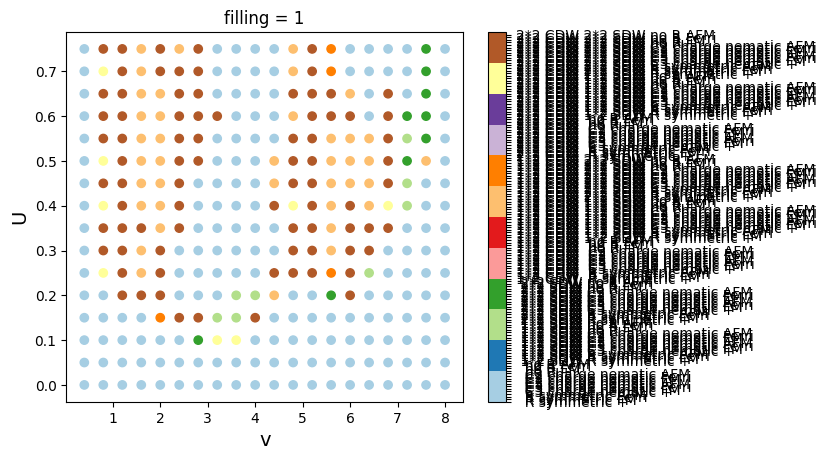

In [44]:
colorbar_ticks_combined = np.arange(len(phase_list_final))
cmap = plt.get_cmap("Paired", len(phase_list_final))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(filling_mesh, u_mesh, c=phase_diagram_based_on_d, cmap=cmap,vmin=0, vmax=len(phase_list_final))
# plt.xlabel(r'$E_{f}$', size = '14')
plt.xlabel('v', size = '14')
plt.ylabel('U', size = '14')
# plt.xlim(3.8,6)
colorbar_ticks = np.arange(len(phase_list_final))
cbar = plt.colorbar()
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels(phase_list_final)
plt.title('filling = 1')

In [45]:
unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_list_final[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(filling_mesh.shape[0]):
    for j in range(filling_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

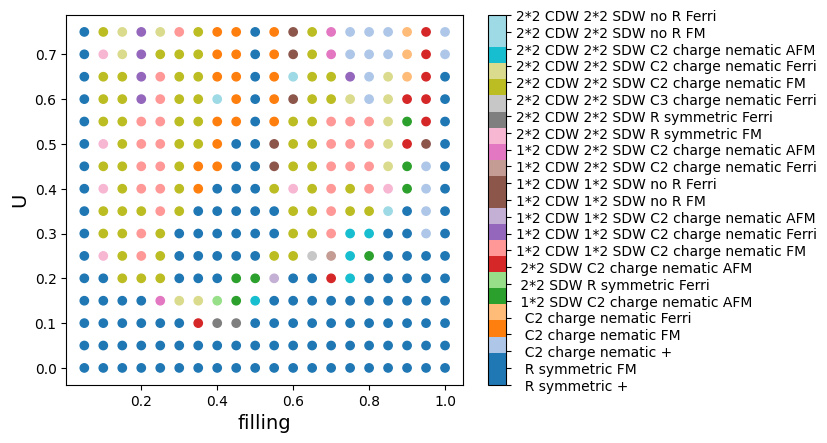

In [46]:
cmap = plt.get_cmap("tab20", len(unique_phase_index))
plt.scatter(filling_mesh/8, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)

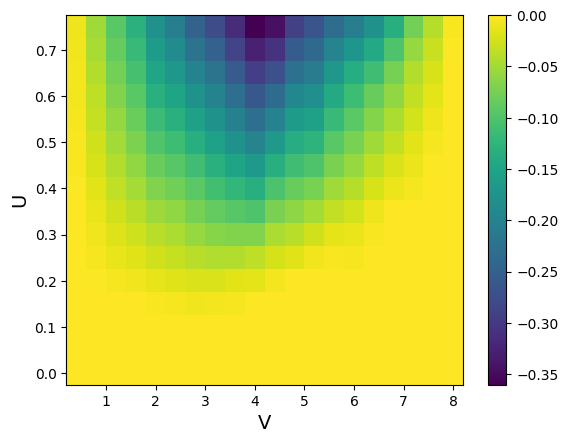

In [47]:
plt.pcolormesh(filling_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

In [48]:
np.mean(final_iteration)

np.float64(74.44703125)

In [49]:
TB_index=np.where(filtered_phase_diagram>4)
simplified_phase_diagram = filtered_phase_diagram.copy()
simplified_phase_diagram[TB_index] = 5

simplified_phase_list = unique_phase_name[:5]+['TSB']


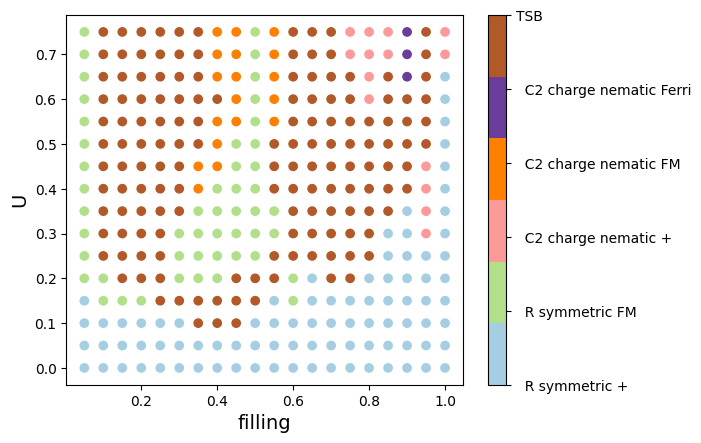

In [50]:
cmap = plt.get_cmap("Paired", len(simplified_phase_list))
plt.scatter(filling_mesh/8, u_mesh, c=simplified_phase_diagram, cmap=cmap)
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
colorbar_ticks = np.arange(len(simplified_phase_list))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(simplified_phase_list)))
cbar.set_ticklabels(simplified_phase_list)

In [51]:
from matplotlib.colors import ListedColormap

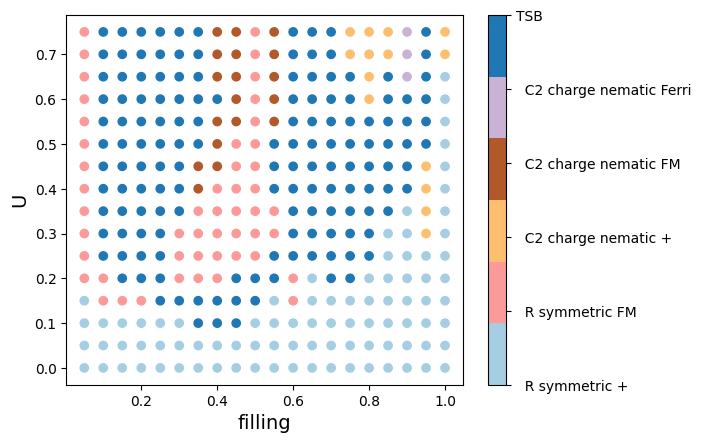

In [52]:
paired = plt.get_cmap("Paired").colors
corlor_index = [0,4,6,11,8,1]
color_list = [paired[i] for i in corlor_index]

cmap = ListedColormap(color_list)
plt.scatter(filling_mesh/8, u_mesh, c=simplified_phase_diagram, cmap=cmap)
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
colorbar_ticks = np.arange(len(simplified_phase_list))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(simplified_phase_list)))
cbar.set_ticklabels(simplified_phase_list)


